IMPORTS

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

CONFIGURES

In [65]:
num_drones = 10
limite_y = 80
limite_x = 100

alcance_comunicacao_jammer = 25
alcance_comunicacao_nos=500

# Posições estáticas dos drones
posicoes = np.array([[16, 30], [18, 48], [44, 15], [23, 73], [45, 73], [50, 50],[66, 32], [37, 38], [12, 15], [51, 35]])

posicao_jammer = np.array([38,50])





LOSS MODEL (Free Space Path Loss)

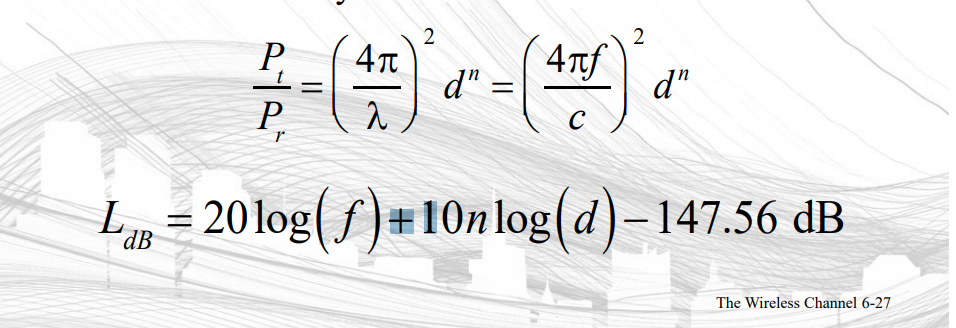

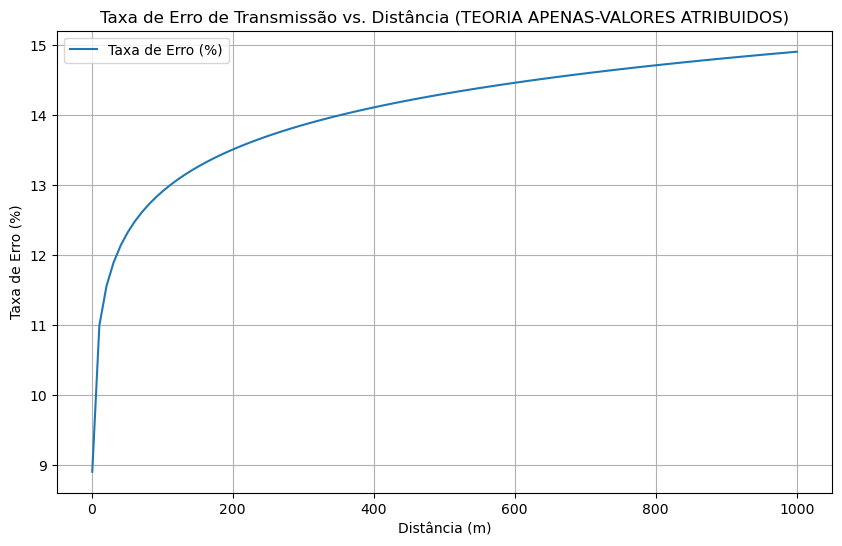

In [66]:


def calcular_fspl(d, f):
    c = 3e8  # Velocidade da luz m/s
    fspl = 20 * np.log10(d) + 20 * np.log10(f) -147.56
    return fspl

def estimar_taxa_erro(prx):
    # Relação simples onde o erro aumenta com a FSPL
    
    erro_base = 0.05  # Erro base em transmissão ideal
    taxa_erro = erro_base + (prx - 1) / 1000  # Suposição de incremento de erro
    return min(max(taxa_erro, 0), 1)  # Limita a taxa de erro entre 0% e 100%

# Configurações so para ver grafico
distancias = np.linspace(1, 1000, 100)  # De 1 a 1000 metros
frequencia = 2.4e9  # Frequência de 2.4 GHz (Wi-Fi)

# Calculando FSPL e taxa de erro
fspl = calcular_fspl(distancias, frequencia)
taxa_erro = np.array([estimar_taxa_erro(f) for f in fspl])

# Plotando
plt.figure(figsize=(10, 6))
plt.plot(distancias, taxa_erro*100, label='Taxa de Erro (%)')
plt.xlabel('Distância (m)')
plt.ylabel('Taxa de Erro (%)')
plt.title('Taxa de Erro de Transmissão vs. Distância (TEORIA APENAS-VALORES ATRIBUIDOS)')
plt.legend()
plt.grid(True)
plt.show()


MODELO FRIIS

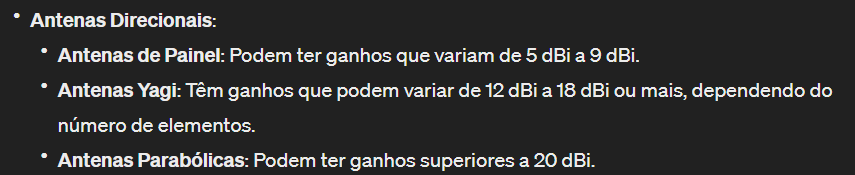

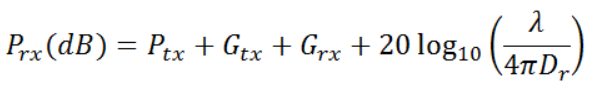

In [67]:

# Definir constantes
c = 3e8  # velocidade da luz em m/s

# Função para calcular Prx em dB
def calcular_Prx_dB(Ptx_dBm, Gtx_dBi, Grx_dBi, Dr_m, f_Hz):
    # Converter frequência para comprimento de onda
    lambda_m = c / f_Hz
    
    # Calcula a potência do sinal recebido
    Prx_dB = Ptx_dBm + Gtx_dBi + Grx_dBi + 20 * np.log10(lambda_m / (4 * np.pi * Dr_m))
    
    return Prx_dB

# Exemplo de uso da função
Ptx_dBm = 20  
Gtx_dBi = 5   
Grx_dBi = 5   
Dr_m = 100    
f_Hz = 2.4e9  

# Calcula Prx em dB
Prx_dB = calcular_Prx_dB(Ptx_dBm, Gtx_dBi, Grx_dBi, Dr_m, f_Hz)

print(f"A potência do sinal recebido é: {Prx_dB} dB")


A potência do sinal recebido é: -50.045997020280794 dB


VISUALIZAR ENXAME

In [68]:


def distancia(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
# Preparando a figura


fig = go.Figure()

# Adiciona os drones
for i in range(num_drones):
    fig.add_trace(go.Scatter(
        x=[posicoes[i, 0]],
        y=[posicoes[i, 1]],
        mode='markers+text',
        marker=dict(size=10, color='orange' if i in afetados_pelo_jammer else 'blue'),
        text=str(i),
        textposition="bottom center",
        showlegend=False  # Oculta esses rastros da legenda
    ))

# Adiciona o jammer
fig.add_trace(go.Scatter(
    x=[posicao_jammer[0]],
    y=[posicao_jammer[1]],
    mode='markers',
    marker=dict(size=12, color='red'),
    name='Jammer'
))

# Adiciona rastros para a legenda
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='blue'), name="Nó não afetado"))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='orange'), name="Nó afetado"))
# O Jammer já está adicionado com a legenda correta

# Configurações do gráfico
fig.update_layout(
    title="Simulação de Modelo de Comunicação Wireless entre Drones",
    xaxis=dict(range=[0, limite_x], autorange=False),
    yaxis=dict(range=[0, limite_y], autorange=False),
    legend_title_text='Legenda',
    legend=dict(traceorder='normal', itemsizing='constant')
)

fig.show()

FUNÇÕES

In [69]:
def encontra_vizinhos(posicoes, alcance_comunicacao_nos):
    num_drones = posicoes.shape[0]
    vizinhos = {}
    for i in range(num_drones):
        vizinhos[i] = []
        for j in range(num_drones):
            if i != j and distancia(posicoes[i], posicoes[j]) <= alcance_comunicacao_nos:
                vizinhos[i].append(j)
    return vizinhos

def verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer):
    afetados_pelo_jammer = []
    for i in range(posicoes.shape[0]):
        if distancia(posicoes[i], posicao_jammer) <= alcance_comunicacao_jammer:
            afetados_pelo_jammer.append(i)
    return afetados_pelo_jammer


def busca_caminho(inicio, destino, vizinhos, afetados_pelo_jammer, caminho=[]):
    caminho = caminho + [inicio]
    if inicio == destino:
        return caminho
    if inicio in afetados_pelo_jammer:
        return None
    for vizinho in vizinhos[inicio]:
        if vizinho not in caminho and vizinho not in afetados_pelo_jammer:
            novo_caminho = busca_caminho(vizinho, destino, vizinhos, afetados_pelo_jammer, caminho)
            if novo_caminho:
                return novo_caminho
    return None

NOS VIZINHOS E NOS AFETADOS PELO JAMMER

In [70]:
vizinhos = encontra_vizinhos(posicoes, alcance_comunicacao_nos)
afetados_pelo_jammer=verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer)

print('Nos Vizinhos:', vizinhos)
print('Nos Afetados Jammer:', afetados_pelo_jammer)


Nos Vizinhos: {0: [1, 2, 3, 4, 5, 6, 7, 8, 9], 1: [0, 2, 3, 4, 5, 6, 7, 8, 9], 2: [0, 1, 3, 4, 5, 6, 7, 8, 9], 3: [0, 1, 2, 4, 5, 6, 7, 8, 9], 4: [0, 1, 2, 3, 5, 6, 7, 8, 9], 5: [0, 1, 2, 3, 4, 6, 7, 8, 9], 6: [0, 1, 2, 3, 4, 5, 7, 8, 9], 7: [0, 1, 2, 3, 4, 5, 6, 8, 9], 8: [0, 1, 2, 3, 4, 5, 6, 7, 9], 9: [0, 1, 2, 3, 4, 5, 6, 7, 8]}
Nos Afetados Jammer: [1, 4, 5, 7, 9]


ESCOLHER TODAS AS ROTAS POSSIVEIS

In [71]:
def encontrar_todas_rotas(vizinhos, inicio, destino, afetados_pelo_jammer):
    # Inicializa a lista de rotas
    rotas = []

    # Função auxiliar de busca em profundidade para encontrar rotas
    def dfs(atual, destino, caminho):
        # Adiciona o nó atual ao caminho
        caminho.append(atual)

        # Se o nó atual é o destino, uma rota foi encontrada
        if atual == destino:
            rotas.append(caminho[:])
        else:
            # Continua a busca a partir dos vizinhos que não estão no caminho atual
            # Alteração aqui: permite que o destino seja um nó afetado, mas não nós intermediários
            for vizinho in vizinhos[atual]:
                if vizinho not in caminho and (vizinho not in afetados_pelo_jammer or vizinho == destino):
                    dfs(vizinho, destino, caminho)
        
        # Remove o nó atual do caminho para backtracking
        caminho.pop()

    # Inicia a busca em profundidade a partir do nó de início
    dfs(inicio, destino, [])

    return rotas

# Supondo que as variáveis 'vizinhos', 'inicio', 'destino', e 'afetados_pelo_jammer' estejam definidas corretamente
# Exemplo de uso
inicio = 0
destino = 9
todas_rotas = encontrar_todas_rotas(vizinhos, inicio, destino, afetados_pelo_jammer)

# Exibir todas as rotas encontradas
print(f"Todas as rotas possíveis de {inicio} para {destino} evitando nós intermédios afetados:")
for rota in todas_rotas:
    print(" -> ".join(map(str, rota)))



Todas as rotas possíveis de 0 para 9 evitando nós intermédios afetados:
0 -> 2 -> 3 -> 6 -> 8 -> 9
0 -> 2 -> 3 -> 6 -> 9
0 -> 2 -> 3 -> 8 -> 6 -> 9
0 -> 2 -> 3 -> 8 -> 9
0 -> 2 -> 3 -> 9
0 -> 2 -> 6 -> 3 -> 8 -> 9
0 -> 2 -> 6 -> 3 -> 9
0 -> 2 -> 6 -> 8 -> 3 -> 9
0 -> 2 -> 6 -> 8 -> 9
0 -> 2 -> 6 -> 9
0 -> 2 -> 8 -> 3 -> 6 -> 9
0 -> 2 -> 8 -> 3 -> 9
0 -> 2 -> 8 -> 6 -> 3 -> 9
0 -> 2 -> 8 -> 6 -> 9
0 -> 2 -> 8 -> 9
0 -> 2 -> 9
0 -> 3 -> 2 -> 6 -> 8 -> 9
0 -> 3 -> 2 -> 6 -> 9
0 -> 3 -> 2 -> 8 -> 6 -> 9
0 -> 3 -> 2 -> 8 -> 9
0 -> 3 -> 2 -> 9
0 -> 3 -> 6 -> 2 -> 8 -> 9
0 -> 3 -> 6 -> 2 -> 9
0 -> 3 -> 6 -> 8 -> 2 -> 9
0 -> 3 -> 6 -> 8 -> 9
0 -> 3 -> 6 -> 9
0 -> 3 -> 8 -> 2 -> 6 -> 9
0 -> 3 -> 8 -> 2 -> 9
0 -> 3 -> 8 -> 6 -> 2 -> 9
0 -> 3 -> 8 -> 6 -> 9
0 -> 3 -> 8 -> 9
0 -> 3 -> 9
0 -> 6 -> 2 -> 3 -> 8 -> 9
0 -> 6 -> 2 -> 3 -> 9
0 -> 6 -> 2 -> 8 -> 3 -> 9
0 -> 6 -> 2 -> 8 -> 9
0 -> 6 -> 2 -> 9
0 -> 6 -> 3 -> 2 -> 8 -> 9
0 -> 6 -> 3 -> 2 -> 9
0 -> 6 -> 3 -> 8 -> 2 -> 9
0 -> 6 -> 3 -> 8 -> 9
0

TAXA DE ERRO PARA CADA VIZINHO

In [72]:
Ptx_dBm = 20 
Gtx_dBi = 5   
Grx_dBi = 5      
f = 2.4e9 


def calcular_Prx_dB(Ptx_dBm, Gtx_dBi, Grx_dBi, d, f):
    """
    Calcula a potência do sinal recebido usando a equação de Friis.
    """
    c = 3e8  # Velocidade da luz em m/s
    lambda_m = c / f  # Comprimento de onda
    L = (4 * np.pi * d / lambda_m)**2
    Prx_dBm = Ptx_dBm + Gtx_dBi + Grx_dBi - 10 * np.log10(L)
    return Prx_dBm


def calcular_potencia_recebida_vizinhos(vizinhos, posicoes):
    prx_resultados = {}
    for drone, seus_vizinhos in vizinhos.items():
        for vizinho in seus_vizinhos:
            d = distancia(posicoes[drone], posicoes[vizinho])
            prx = calcular_Prx_dB(Ptx_dBm, Gtx_dBi, Grx_dBi, d, frequencia)
            prx_resultados[f"Drone {drone} para Vizinho {vizinho}"] = prx
    return prx_resultados

prx_resultados = calcular_potencia_recebida_vizinhos(vizinhos, posicoes)

# Exibir os resultados
for chave, prx in prx_resultados.items():
    print(f"{chave}: Prx = {prx:.2f} dBm")

Drone 0 para Vizinho 1: Prx = -35.20 dBm
Drone 0 para Vizinho 2: Prx = -40.08 dBm
Drone 0 para Vizinho 3: Prx = -42.83 dBm
Drone 0 para Vizinho 4: Prx = -44.34 dBm
Drone 0 para Vizinho 5: Prx = -41.97 dBm
Drone 0 para Vizinho 6: Prx = -44.03 dBm
Drone 0 para Vizinho 7: Prx = -37.08 dBm
Drone 0 para Vizinho 8: Prx = -33.87 dBm
Drone 0 para Vizinho 9: Prx = -41.02 dBm
Drone 1 para Vizinho 0: Prx = -35.20 dBm
Drone 1 para Vizinho 2: Prx = -42.51 dBm
Drone 1 para Vizinho 3: Prx = -38.18 dBm
Drone 1 para Vizinho 4: Prx = -41.36 dBm
Drone 1 para Vizinho 5: Prx = -40.17 dBm
Drone 1 para Vizinho 6: Prx = -44.13 dBm
Drone 1 para Vizinho 7: Prx = -36.68 dBm
Drone 1 para Vizinho 8: Prx = -40.56 dBm
Drone 1 para Vizinho 9: Prx = -41.04 dBm
Drone 2 para Vizinho 0: Prx = -40.08 dBm
Drone 2 para Vizinho 1: Prx = -42.51 dBm
Drone 2 para Vizinho 3: Prx = -45.85 dBm
Drone 2 para Vizinho 4: Prx = -45.32 dBm
Drone 2 para Vizinho 5: Prx = -41.05 dBm
Drone 2 para Vizinho 6: Prx = -38.93 dBm
Drone 2 para Viz